In [1]:
import torch
import torchvision

In [2]:
from torchvision.models import alexnet

In [11]:
model = alexnet(weights=torchvision.models.AlexNet_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\YUI2KOR/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|████████████████████████████████████████████████████████████████████████████████| 233M/233M [08:41<00:00, 469kB/s]


In [12]:
# models.AlexNet_Weights.IMAGENET1K_V1

In [13]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a pretrained model
model = models.resnet50(pretrained=True)
model.eval()

C:\Users\YUI2KOR\BOSCH\KNOWLEDGE\NOTEBOOK\env_notebook\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\YUI2KOR\BOSCH\KNOWLEDGE\NOTEBOOK\env_notebook\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
class LRP:
    def __init__(self, model):
        self.model = model

    def forward(self, x):
        # Forward pass to get the predictions
        self.activations = []
        self.gradients = []
        self.handles = []

        # Register hooks to capture the activations
        for layer in self.model.children():
            self.handles.append(layer.register_forward_hook(self.save_activation))
        
        output = self.model(x)
        
        # Remove hooks
        for handle in self.handles:
            handle.remove()
        
        return output

    def save_activation(self, module, input, output):
        self.activations.append(output)

    def backward(self, relevance_scores):
        # Backward pass to redistribute relevance scores
        for activation in reversed(self.activations):
            relevance_scores = activation * relevance_scores
            relevance_scores = relevance_scores / (activation.sum(dim=1, keepdim=True) + 1e-10)
        
        return relevance_scores

    def generate_heatmap(self, input_image, target_class):
        output = self.forward(input_image)
        
        # Initialize the relevance score with the output of the target class
        relevance_scores = torch.zeros_like(output)
        relevance_scores[0, target_class] = 1.0
        
        # Backpropagate the relevance scores
        relevance_scores = self.backward(relevance_scores)
        
        # Aggregate relevance scores over the channels
        heatmap = relevance_scores.sum(dim=1).detach().numpy()
        return heatmap

In [17]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image

image_path = r"C:\Users\YUI2KOR\BOSCH\BOSCH_PROJECT\PDCA\CAM_FRONT\n008-2018-05-21-11-06-59-0400__CAM_FRONT__1526915243012465.jpg"
input_image = preprocess_image(image_path)

In [20]:
input_image.shape

torch.Size([1, 3, 224, 224])

In [19]:
# Choose the target class (e.g., class 243 is 'bull mastiff' in ImageNet)
target_class = 243

# Initialize LRP
lrp = LRP(model)

# Generate the heatmap
heatmap = lrp.generate_heatmap(input_image, target_class)

# Visualize the heatmap
heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
heatmap /= heatmap.max()  # Normalize the heatmap
heatmap = heatmap[0]  # Take the first (and only) image in the batch

# Overlay the heatmap on the original image
original_image = Image.open(image_path).resize((224, 224))
heatmap_image = plt.imshow(original_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap with transparency
plt.show()

RuntimeError: The size of tensor a (7) must match the size of tensor b (1000) at non-singleton dimension 3

In [30]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a pretrained ResNet model
model = models.resnet50(pretrained=True)
model.eval()

C:\Users\YUI2KOR\BOSCH\KNOWLEDGE\NOTEBOOK\env_notebook\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\YUI2KOR\BOSCH\KNOWLEDGE\NOTEBOOK\env_notebook\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image

image_path = r"C:\Users\YUI2KOR\BOSCH\BOSCH_PROJECT\PDCA\CAM_FRONT\n008-2018-05-21-11-06-59-0400__CAM_FRONT__1526915243012465.jpg"
input_image = preprocess_image(image_path)

In [32]:
from captum.attr import LRP
from captum.attr import visualization as viz

# Initialize LRP
lrp = LRP(model)

# Choose the target class (e.g., class 243 is 'bull mastiff' in ImageNet)
target_class = 847

# Compute LRP attributions
attributions = lrp.attribute(input_image, target=target_class)

# Visualize the attributions
heatmap = attributions.squeeze().detach().numpy()

In [33]:
#!pip install captum

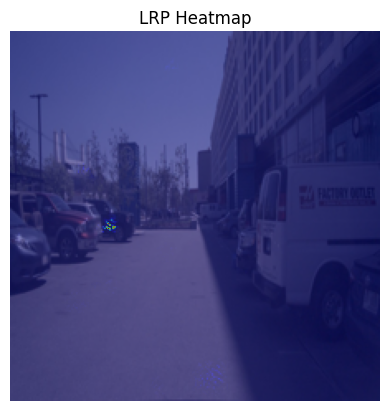

In [34]:
# ReLU on the heatmap
heatmap = np.maximum(heatmap, 0)

# Normalize the heatmap
heatmap = heatmap / heatmap.max()

# Squeeze the heatmap to remove single-dimensional entries
heatmap = heatmap.mean(axis=0)  # Take the mean over channels if necessary

# Plot the original image with the heatmap
original_image = Image.open(image_path).resize((224, 224))

plt.imshow(original_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap with transparency
plt.title("LRP Heatmap")
plt.axis('off')
plt.show()